# IDs from Juno

See following notebooks for details:

-   [State data](./state.ipynb)

## Setup

::: {#cell-2 .cell 0=‘h’ 1=‘i’ 2=‘d’ 3=‘e’ execution_count=1}

``` python
%load_ext autoreload
%autoreload 2
```

:::

In [2]:
from discontinuitypy.datasets import IDsDataset
import polars as pl
from fastcore.utils import walk

from loguru import logger

from datetime import timedelta

20-Feb-24 11:33:08: UserWarning: Traceback (most recent call last):
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
    from . import skintegrate
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
    from sklearn.base import BaseEstimator
ModuleNotFoundError: No module named 'sklearn'


20-Feb-24 11:33:08: UserWarning: pdpipe: Scikit-learn or skutil import failed. Scikit-learn-dependent pipeline stages will not be loaded.

20-Feb-24 11:33:08: UserWarning: Traceback (most recent call last):
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>
    from . import nltk_stages
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/nltk_stages.py", line 19, in <module>
    import nltk
ModuleNotFoundError: No module named 'nltk'


20-Feb-2

In [3]:
mission = "JNO"
ts = timedelta(seconds=1)
tau = timedelta(seconds=60)


data_dir = '../../../data'
dir_path = f'{data_dir}/03_primary/JNO_MAG_ts_{ts.seconds}s'
juno_state_path = f'{data_dir}/03_primary/JNO_STATE_ts_3600s.parquet'
vec_cols = ['v_x', 'v_y', 'v_z']

format = 'arrow'
fname = f'events.{mission}.ts_{ts.total_seconds():.2f}s_tau_{tau.seconds}s.{format}'
output_path = f'{data_dir}/05_reporting/{fname}'

In [4]:
plasma_data = pl.scan_parquet(juno_state_path).sort('time')
logger.info(plasma_data.columns)

2024-02-20 11:33:08.917 | INFO     | __main__:<module>:2 - ['radial_distance', 'plasma_density', 'plasma_temperature', 'time', 'model_b_r', 'model_b_t', 'model_b_n', 'v_x', 'v_y', 'v_z', 'plasma_speed', 'B_background_x', 'B_background_y', 'B_background_z']

## Standard Process

In [ ]:
juno_events = []
for mag_path in walk(dir_path):
    mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

    _juno_events = (
        IDsDataset(
            mag_data=mag_data,
            plasma_data=plasma_data,
            tau=tau,
            ts=ts,
            vec_cols=vec_cols,
            density_col="plasma_density",
            speed_col="plasma_speed",
            temperature_col="plasma_temperature",
        )
        .find_events(return_best_fit=False)
        .update_candidates_with_plasma_data()
        .events
    )
    
    juno_events.append(_juno_events)
    
juno_ids_dataset = IDsDataset(
    events=pl.concat(juno_events),
    mag_data= pl.scan_parquet(list(walk(dir_path))).drop('X', 'Y', 'Z').sort('time')
)

juno_ids_dataset.export(output_path)

## Check the discontinuity in Juno cruise phase

### Full time resolution data

0.03 s - 0.125 s time resolution

In [5]:
from space_analysis.missions.juno.fgm import download_data
from discontinuitypy.utils.basic import resample
from toolz import curry
from pipe import select
from fastcore.utils import mkdir
import os

In [6]:
def preprocess(
    fp,
    every = timedelta(seconds = 0.125),
    dir_path = "../../../data/02_intermediate/JNO_MAG_8hz",
    update = False
):
    fname = fp.split('/')[-1]
    
    output_path = f"{dir_path}/{fname}"
    
    if not os.path.exists(output_path) or update:
        mkdir(dir_path, parents=True, exist_ok = True)
        df = pl.scan_ipc(fp).sort('time').pipe(resample, every = every)
        df.collect().write_ipc(output_path)
    return output_path

@curry
def process(fp, ids_dataset: IDsDataset, sparse_num = 10, **kwargs):
    df = pl.scan_ipc(fp).sort('time').unique('time')

    ids_dataset.data = df
    
    return ids_dataset.find_events(return_best_fit=False, sparse_num = sparse_num, **kwargs).update_candidates_with_plasma_data().events

In [7]:
def split_list(l, n):
    if isinstance(l, map):
        l = list(l)
    
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [8]:
mag_paths = list(download_data(datatype="FULL") | select(preprocess))

In [9]:
ts = timedelta(seconds=0.125)
tau = timedelta(seconds=20)
method = "derivative"
# method = "fit"

fname = f'events.{mission}.{method}.ts_{ts.total_seconds():.2f}s_tau_{tau.seconds}s.{format}'
output_path = f'{data_dir}/05_reporting/{fname}'
logger.info(output_path)

2024-02-18 19:32:19.893 | INFO     | __main__:<module>:8 - ../../../data/05_reporting/events.JNO.derivative.ts_0.12s_tau_20s.arrow

In [10]:
ids_ds = IDsDataset(
    plasma_data=plasma_data,
    tau=tau,
    ts=ts,
    vec_cols=vec_cols,
    density_col="plasma_density",
    speed_col="plasma_speed",
    temperature_col="plasma_temperature",
)

Reasonably splitting the data files may accelerate the processing.

In [12]:
fps = split_list(mag_paths, n=100)

func = process(ids_dataset = ids_ds, sparse_num = 10, method = method)

ids_ds.data = pl.scan_ipc(mag_paths)
ids_ds.events = pl.concat(fps | select(func)) 
ids_ds.export(output_path)

18-Feb-24 19:34:15: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:34:35: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:34:40: RuntimeWarning: invalid value encountered in divide

18-Feb-24 19:34:58: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:35:15: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:35:28: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:35:40: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:35:42: RuntimeWarning: invalid value encountered in divide

18-Feb-24 19:35:58: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

18-Feb-24 19:36:10: UserWarn

IDsDataset(name=None, events=shape: (149_383, 96)
┌─────────────┬────────────┬─────┬──────────┬───┬────────────┬───────────┬────────────┬────────────┐
│ time        ┆ index_diff ┆ len ┆ std      ┆ … ┆ v.ion.chan ┆ B.change  ┆ v.Alfven.c ┆ v.Alfven.c │
│ ---         ┆ ---        ┆ --- ┆ ---      ┆   ┆ ge.l       ┆ ---       ┆ hange      ┆ hange.l    │
│ datetime[ns ┆ f64        ┆ u32 ┆ f64      ┆   ┆ ---        ┆ f64       ┆ ---        ┆ ---        │
│ ]           ┆            ┆     ┆          ┆   ┆ f64        ┆           ┆ f64        ┆ f64        │
╞═════════════╪════════════╪═════╪══════════╪═══╪════════════╪═══════════╪════════════╪════════════╡
│ 2011-08-25  ┆ 1.705243   ┆ 160 ┆ 2.443084 ┆ … ┆ NaN        ┆ 0.001359  ┆ NaN        ┆ NaN        │
│ 15:25:30    ┆            ┆     ┆          ┆   ┆            ┆           ┆            ┆            │
│ 2011-08-25  ┆ 0.725398   ┆ 160 ┆ 1.261811 ┆ … ┆ NaN        ┆ -0.013523 ┆ NaN        ┆ NaN        │
│ 15:27:20    ┆            ┆     ┆       

## Superposed epoch analysis

In [57]:
from discontinuitypy.utils.basic import df2ts
from xarray_einstats import linalg

from sea_norm import sean
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from discontinuitypy.integration import J_FACTOR

def keep_good_fit(df: pl.DataFrame, rsquared = 0.95):
    return df.filter(pl.col('fit.stat.rsquared') > rsquared)

In [58]:
def get_dBdt_data(data):
    # TODO: compress data first
    ts = df2ts(data)

    vec_diff = ts.differentiate("time", datetime_unit="s")
    vec_diff_mag: xr.DataArray = linalg.norm(vec_diff, dims="v_dim")
    return vec_diff_mag.to_dataframe(name="dBdt")

def sea_ids(
    ds: IDsDataset,
    cols = ['t.d_start', 't.d_time', 't.d_end'],
    bins = [10 , 10],
    return_data = True
):
    # converting to a list of numpy arrays
    
    ds.events = keep_good_fit(ds.events)
    
    sea_events = [col.to_numpy() for col in ds.events[cols]]
    
    data = get_dBdt_data(ds.data)
    
    data = pd.merge_asof(
        data,
        ids_ds.events[["time", "v_k", 'j_Alfven']].to_pandas().set_index("time").sort_index(),
        left_index=True,
        right_index=True,
        direction="nearest",
    )

    data['j_k'] = data['dBdt'] / data['v_k'] * J_FACTOR
    data['j_k_norm'] = data['j_k'] / data['j_Alfven']
    
    return sean(data, sea_events, bins, return_data=return_data)

def plot_SEA(SEAarray, meta):
    cols = meta['sea_cols']
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, squeeze=True, figsize=(5, 8))

    if len(cols) == 1:
        axes = [axes]

    # loop over columns that were analyzed
    for c, ax in zip(cols, axes):
        # for each column identify the column titles which
        # have 'c' in the title and those that don't have
        # 'cnt' in the title
        # e.g. for AE columns
        # AE_mean, AE_median, AE_lowq, AE_upq, AE_cnt
        # fine columns AE_mean, AE_median, AE_lowq, AE_upq
        # mask = SEAarray.columns.str.startswith(c) & ~SEAarray.columns.str.endswith("cnt")
        mask = [c+'_mean', c+'_median', c+'_lowq', c+'_upq']

        # plot the SEA data
        SEAarray.loc[:, mask].plot(
            ax=ax,
            style=["r-", "b-", "b--", "b--"],
            xlabel="Normalized Time",
            ylabel=c.replace("_", " "),
            legend=False,
        )

    return fig, axes


### First year

In [59]:
mag_path = sorted(list(walk(dir_path)))[0]
tau = timedelta(seconds=60)
mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

ids_ds = (
    IDsDataset(
        mag_data=mag_data,
        plasma_data=plasma_data,
        tau=tau,
        ts=ts,
        vec_cols=vec_cols,
        density_col="plasma_density",
        speed_col="plasma_speed",
        temperature_col="plasma_temperature",
    )
    .find_events(return_best_fit=True)
    .update_candidates_with_plasma_data()
)

20-Feb-24 12:27:21: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.


In [60]:
SEAarray, meta, p1data, p2data = sea_ids(ids_ds)

fig, axes = plot_SEA(SEAarray, meta)

100%|██████████| 8151/8151 [00:03<00:00, 2371.81it/s]

``` python
ids_ds.plot_candidates(num=20, plot_fit_data=True, predicates=(pl.col('fit.stat.rsquared') > 0.95))
```

### Last year

In [54]:
# mag_path = sorted(list(walk(dir_path)))[-1]
tau = timedelta(seconds=300)
tau = timedelta(seconds=60)
mag_path = sorted(list(walk(dir_path)))[-1]
mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

ids_ds = (
    IDsDataset(
        mag_data=mag_data,
        plasma_data=plasma_data,
        tau=tau,
        ts=ts,
        vec_cols=vec_cols,
        density_col="plasma_density",
        speed_col="plasma_speed",
        temperature_col="plasma_temperature",
    )
    .find_events(return_best_fit=True)
    .update_candidates_with_plasma_data()
)

20-Feb-24 12:24:47: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.


#### Superposed epoch analysis

In [56]:
SEAarray, meta, p1data, p2data = sea_ids(ids_ds)

fig, axes = plot_SEA(SEAarray, meta)

100%|██████████| 1769/1769 [00:00<00:00, 2332.25it/s]

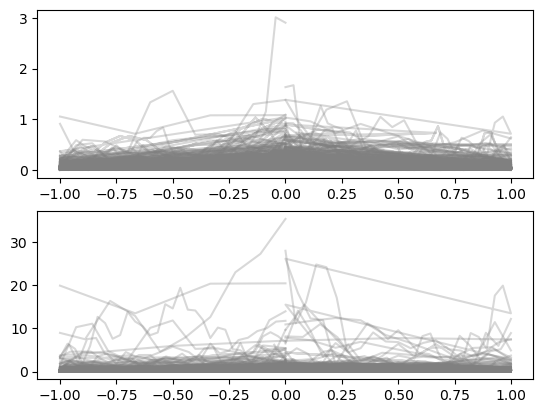

In [42]:
groupby = 'index'
columns = ['dBdt', 'j_k']

# Plot each group
fig, axes = plt.subplots(nrows=len(columns))

if len(columns) == 1:
    axes = [axes]

p1groups = p1data.groupby(groupby)
p2groups = p2data.groupby(groupby)

for ax, column in zip(axes, columns):
    for name, group in p1groups:
        ax.plot(group['t_norm'] -1 , group[column], color='grey', alpha=0.3)
        
    for name, group in p2groups:
        ax.plot(group['t_norm'], group[column], color='grey', alpha=0.3)

# plt.yscale('log')
plt.show()


``` python
ids_ds.plot_candidates(num=20, plot_fit_data=True, predicates=(pl.col('fit.stat.rsquared') > 0.95))
```

## Processing the whole data

## Obsolete

### Estimate

1 day of data resampled by 1 sec is about 12 MB.

So 1 year of data is about 4 GB, and 6 years of JUNO Cruise data is about 24 GB.

Downloading rate is about 250 KB/s, so it will take about 3 days to download all the data.

In [ ]:
num_of_files = 6*365
jno_file_size = 12e3
thm_file_size = 40e3
files_size = jno_file_size + thm_file_size
downloading_rate = 250
processing_rate = 1/60

time_to_download = num_of_files * files_size / downloading_rate / 60 / 60
space_required = num_of_files * files_size / 1e6
time_to_process = num_of_files / processing_rate / 60 / 60

print(f"Time to download: {time_to_download:.2f} hours")
print(f"Disk space required: {space_required:.2f} GB")
print(f"Time to process: {time_to_process:.2f} hours")